# REINFORCE Algorithm: Mathematical Background and Step-by-Step Calculation

Here's a Python implementation of the REINFORCE algorithm with explanations for each step. For simplicity, I'll create a mock environment where the agent learns to reach a goal in a 1-dimensional space. The agent receives a positive reward for reaching the goal and a negative reward otherwise.

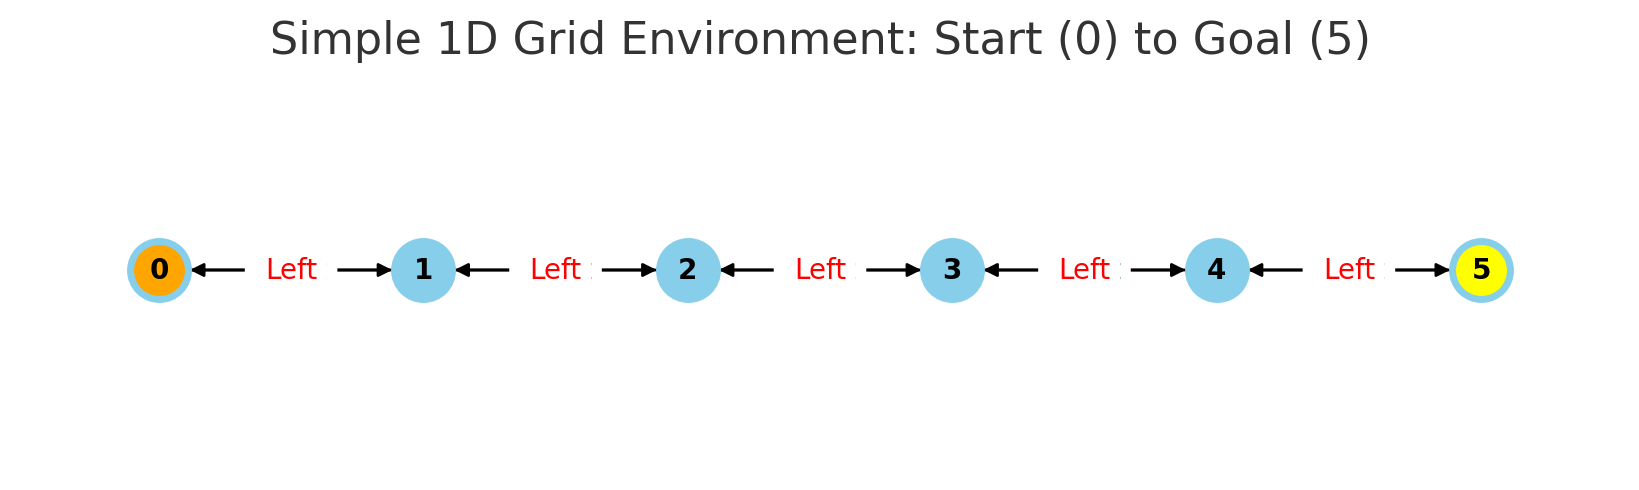


## Mathematical Background of REINFORCE

The REINFORCE algorithm uses policy gradient methods to optimize a policy $\pi_{\theta}(a|s)$ with parameters $\theta$ by maximizing the expected reward $J(\theta)$ directly through gradient ascent.

### Objective of REINFORCE
The objective function for the policy is the expected return:
\[
J(\theta) = \mathbb{E}_{\pi_\theta} \left[ G_t \right]
\]
where
\[
G_t = \sum_{k=0}^{\infty} \gamma^k r_{t+k}
\]
is the discounted return at timestep $t$, and $\gamma$ is the discount factor.

### Gradient of the Objective
The gradient of $J(\theta)$ with respect to the policy parameters $\theta$ can be derived as:
\[
\nabla_\theta J(\theta) = \mathbb{E}_{\pi_\theta} \left[ \nabla_\theta \log \pi_\theta(a_t | s_t) \cdot G_t \right]
\]
This equation tells us:
- Sample actions according to the current policy.
- Compute the return $G_t$ following each action.
- Update $\theta$ using the product of the log-probability of the action and the return $G_t$.

## Step-by-Step Calculations for One Episode

To show how the code translates this math into steps, we'll walk through a single episode using a small discount factor and sample reward values. We'll assume an episode length of 3, with a state-action sequence of 3 steps.

Let's define:
- **Discount factor** ($\gamma$): 0.99
- **Rewards in the episode**: $[-1, -1, 10]$ (agent gets a final large reward on reaching the goal)

### Episode Generation
The agent follows the policy, which samples actions based on the probabilities output by the policy network. For simplicity, assume it receives rewards as follows:

| Step | State ($s$) | Action ($a$) | Reward ($r$) |
|------|-------------|--------------|--------------|
| 1    | 0           | Right        | -1           |
| 2    | 1           | Right        | -1           |
| 3    | 5           | Goal (Right) | 10           |

### Calculate Returns $G_t$
For each step in reverse order, we calculate the return $G_t = r_t + \gamma G_{t+1}$.

- **Step 3:** $G_3 = r_3 = 10$
- **Step 2:** $G_2 = r_2 + \gamma G_3 = -1 + 0.99 \times 10 = 8.9$
- **Step 1:** $G_1 = r_1 + \gamma G_2 = -1 + 0.99 \times 8.9 = 7.811$

So, the returns for each timestep are $G_1 = 7.811$, $G_2 = 8.9$, and $G_3 = 10$.

### Compute Log Probabilities of Actions
Suppose the policy network outputs probabilities for actions Left and Right at each state. For instance, the network might give a 30% probability for Left and 70% for Right. The log probabilities for chosen actions could look like:

- **Step 1:** $\log \pi_\theta(\text{Right} | s = 0) = \log(0.7) \approx -0.357$
- **Step 2:** $\log \pi_\theta(\text{Right} | s = 1) = \log(0.7) \approx -0.357$
- **Step 3:** $\log \pi_\theta(\text{Right} | s = 5) = \log(0.7) \approx -0.357$

### Calculate the Policy Gradient and Loss
Now, we combine these values to compute the loss for gradient ascent. The loss for each timestep is $- \log \pi_\theta(a_t | s_t) \cdot G_t$, and the total loss is their sum:

- **Step 1:** $- \log \pi_\theta(\text{Right} | s = 0) \cdot G_1 \approx -(-0.357) \cdot 7.811 = 2.788$
- **Step 2:** $- \log \pi_\theta(\text{Right} | s = 1) \cdot G_2 \approx -(-0.357) \cdot 8.9 = 3.177$
- **Step 3:** $- \log \pi_\theta(\text{Right} | s = 5) \cdot G_3 \approx -(-0.357) \cdot 10 = 3.57$

**Total Loss for the episode:** $2.788 + 3.177 + 3.57 = 9.535$

### Gradient Update
We backpropagate this total loss and update the policy network parameters.


# Code

Episode 0, Total Reward: -10
Episode 100, Total Reward: -10
Episode 200, Total Reward: 4
Episode 300, Total Reward: 6
Episode 400, Total Reward: 6


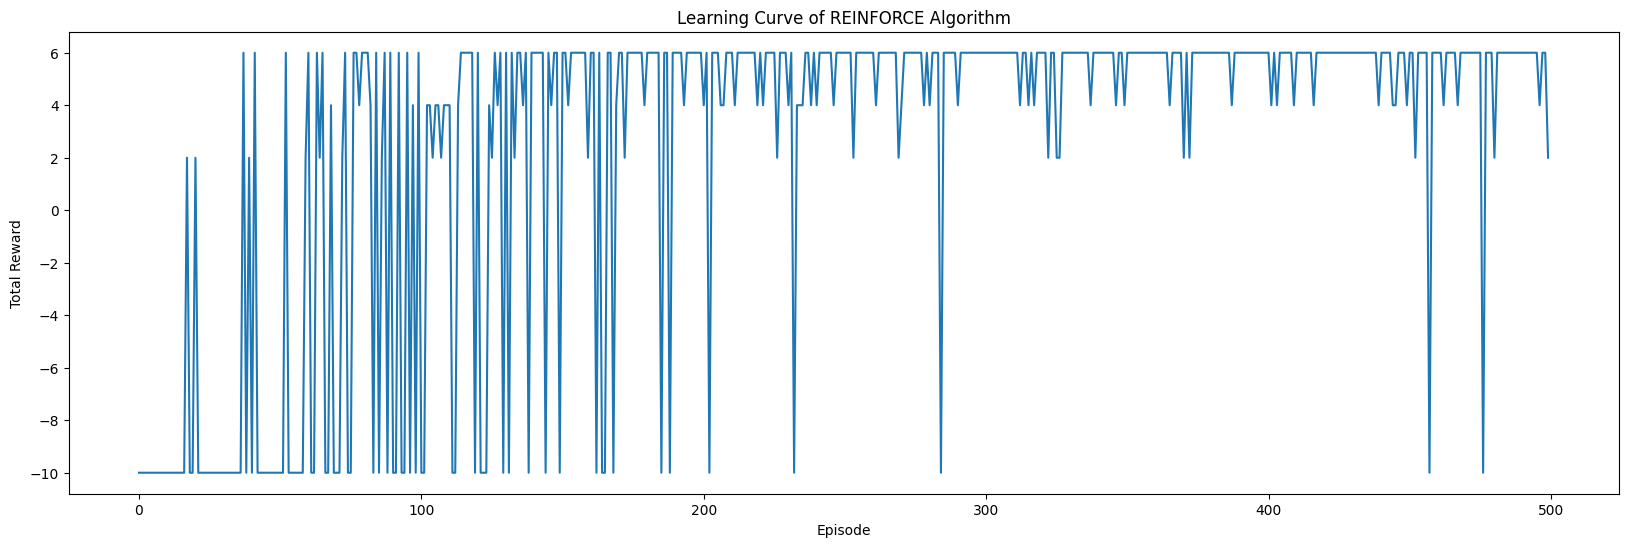

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

# Define the environment
class SimpleEnvironment:
    def __init__(self):
        self.goal_position = 5
        self.start_position = 0
        self.current_position = self.start_position
        self.max_steps = 10  # Limit the number of steps per episode

    def reset(self):
        self.current_position = self.start_position
        return self.current_position

    def step(self, action):
        # Update the position based on the action (0 = left, 1 = right)
        if action == 1:  # move right
            self.current_position += 1
        elif action == 0:  # move left
            self.current_position -= 1

        # Check if the goal is reached
        if self.current_position == self.goal_position:
            return self.current_position, 10, True  # reward of 10 and episode ends
        else:
            return self.current_position, -1, False  # reward of -1 for each step until the goal

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Linear(1, 2)  # Input: state (position), Output: probabilities for 2 actions (left, right)

    def forward(self, x):
        x = self.fc(x)
        return Categorical(logits=x)  # Categorical distribution over actions

# Initialize the policy and optimizer
policy = PolicyNetwork()
optimizer = optim.Adam(policy.parameters(), lr=0.01)

# Generate an episode
def generate_episode(env, policy):
    states, actions, rewards = [], [], []
    state = env.reset()

    for _ in range(env.max_steps):
        state_tensor = torch.tensor([state], dtype=torch.float32)  # Convert state to tensor
        dist = policy(state_tensor)  # Get action distribution from policy
        action = dist.sample()  # Sample an action based on the distribution

        # Store state, action, and reward for this step
        states.append(state_tensor)
        actions.append(action)

        # Take action in environment
        next_state, reward, done = env.step(action.item())
        rewards.append(reward)

        state = next_state  # Move to the next state
        if done:
            break

    return states, actions, rewards

# Compute cumulative returns
def compute_returns(rewards, gamma=0.99):
    returns = []
    G = 0
    for reward in reversed(rewards):
        G = reward + gamma * G
        returns.insert(0, G)  # Insert at the beginning to reverse the order
    return returns

# Update policy
def update_policy(states, actions, returns):
    loss = 0
    for state, action, G in zip(states, actions, returns):
        dist = policy(state)  # Get action distribution for the state
        log_prob = dist.log_prob(action)  # Log probability of the chosen action
        loss += -log_prob * G  # Multiply by return and accumulate the loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()  # Update policy parameters

# Training the model and tracking rewards for each episode
env = SimpleEnvironment()
num_episodes = 500  # Number of episodes for training
rewards_per_episode = []


# Training the model and tracking rewards for each episode
env = SimpleEnvironment()
num_episodes = 500 # Number of episodes for training
rewards_per_episode = []

for episode in range(num_episodes):
    states, actions, rewards = generate_episode(env, policy)
    returns = compute_returns(rewards)
    update_policy(states, actions, returns)
    total_reward = sum(rewards)
    rewards_per_episode.append(total_reward)

    # Print progress every 100 episodes
    if episode % 100 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}")

# Plotting the learning curve
plt.figure(figsize=(20, 6))
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Learning Curve of REINFORCE Algorithm")
plt.show()


# Python Code to Track Step-by-Step Values

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

# Define the environment
class SimpleEnvironment:
    def __init__(self):
        self.goal_position = 5
        self.start_position = 0
        self.current_position = self.start_position
        self.max_steps = 10  # Limit the number of steps per episode

    def reset(self):
        self.current_position = self.start_position
        return self.current_position

    def step(self, action):
        if action == 1:  # move right
            self.current_position += 1
        elif action == 0:  # move left
            self.current_position -= 1

        if self.current_position == self.goal_position:
            return self.current_position, 10, True  # reward of 10 and episode ends
        else:
            return self.current_position, -1, False  # reward of -1 for each step until the goal

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Linear(1, 2)

    def forward(self, x):
        x = self.fc(x)
        return Categorical(logits=x)

# Initialize the policy and optimizer
policy = PolicyNetwork()
optimizer = optim.Adam(policy.parameters(), lr=0.01)

# Generate an episode
def generate_episode(env, policy):
    states, actions, rewards = [], [], []
    state = env.reset()

    for _ in range(env.max_steps):
        state_tensor = torch.tensor([state], dtype=torch.float32)
        dist = policy(state_tensor)
        action = dist.sample()

        states.append(state_tensor)
        actions.append(action)

        next_state, reward, done = env.step(action.item())
        rewards.append(reward)

        state = next_state
        if done:
            break

    return states, actions, rewards

# Compute cumulative returns with formula printing
def compute_returns(rewards, gamma=0.99):
    returns = []
    G = 0
    print("\nCalculating Returns (Reward-to-go) for each step in reverse order:")
    for t in reversed(range(len(rewards))):
        G = rewards[t] + gamma * G
        returns.insert(0, G)
        print(f"  Step {t + 1}: Reward r_t = {rewards[t]}, G_t = r_t + γ * G_(t+1)")
        print(f"    G_{t} = {rewards[t]:.3f} + {gamma} * {G - rewards[t]:.3f} = {G:.3f}")
    return returns

# Update policy with logging for each step, including formulas
def update_policy_with_logging(states, actions, returns):
    total_loss = 0
    for step, (state, action, G) in enumerate(zip(states, actions, returns)):
        dist = policy(state)
        log_prob = dist.log_prob(action)
        loss = -log_prob * G
        total_loss += loss

        # Print details for each step, including formulas
        print(f"\nStep {step + 1}:")
        print(f"  State = {state.item()}, Action = {action.item()}")
        print(f"  Reward-to-go (G) = {G:.3f}")
        print(f"  Formula for Log Probability: log(π_θ(a|s))")
        print(f"    Log Probability = log(π_θ({action.item()}|{state.item()})) = {log_prob.item():.3f}")
        print(f"  Formula for Loss at this step: -log(π_θ(a|s)) * G")
        print(f"    Loss = -({log_prob.item():.3f}) * {G:.3f} = {loss.item():.3f}")

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Print total loss for the episode, including formula
    print(f"\nTotal Loss for the episode (sum of step losses): {total_loss.item():.3f}")
    print("Formula for Total Loss: Σ[-log(π_θ(a|s)) * G] for each step in the episode\n")

# Main training loop
env = SimpleEnvironment()
num_episodes = 5  # Set to a small number to see detailed output for each episode

for episode in range(num_episodes):
    print(f"--- Episode {episode + 1} ---")
    states, actions, rewards = generate_episode(env, policy)
    returns = compute_returns(rewards)
    update_policy_with_logging(states, actions, returns)


--- Episode 1 ---

Calculating Returns (Reward-to-go) for each step in reverse order:
  Step 5: Reward r_t = 10, G_t = r_t + γ * G_(t+1)
    G_4 = 10.000 + 0.99 * 0.000 = 10.000
  Step 4: Reward r_t = -1, G_t = r_t + γ * G_(t+1)
    G_3 = -1.000 + 0.99 * 9.900 = 8.900
  Step 3: Reward r_t = -1, G_t = r_t + γ * G_(t+1)
    G_2 = -1.000 + 0.99 * 8.811 = 7.811
  Step 2: Reward r_t = -1, G_t = r_t + γ * G_(t+1)
    G_1 = -1.000 + 0.99 * 7.733 = 6.733
  Step 1: Reward r_t = -1, G_t = r_t + γ * G_(t+1)
    G_0 = -1.000 + 0.99 * 6.666 = 5.666

Step 1:
  State = 0.0, Action = 1
  Reward-to-go (G) = 5.666
  Formula for Log Probability: log(π_θ(a|s))
    Log Probability = log(π_θ(1|0.0)) = -0.407
  Formula for Loss at this step: -log(π_θ(a|s)) * G
    Loss = -(-0.407) * 5.666 = 2.308

Step 2:
  State = 1.0, Action = 1
  Reward-to-go (G) = 6.733
  Formula for Log Probability: log(π_θ(a|s))
    Log Probability = log(π_θ(1|1.0)) = -0.229
  Formula for Loss at this step: -log(π_θ(a|s)) * G
    Loss 